In [1]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from model_settings import ms
from df_collector import df_collector
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
root = Path().resolve().parent.parent
df_collector.root = root
models_dir = os.path.join(root,ms.trained_models)
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}")


##################
# training start #
##################

Wed Nov  6 23:26:50 2024


In [2]:
data = df_collector.cboe_spx_barriers()
pricename = [f for f in data.columns if f.find('_price')!=-1 and f.find('spot_')==-1][0]
filetag = f'cboe spx {pricename[:pricename.find('_',0)]}'
data = data[data[pricename]<data['spot_price']]
data = data[data[pricename]>data['spot_price']*0.01].reset_index(drop=True)
og_count = data.shape[0]
print('data collected')
data

data collected


,spot_price,strike_price,barrier,days_to_maturity,updown,outin,w,barrier_type_name,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,calculation_date,date,barrier_price
0,4424.00000,3981.60000,2212.00000,60,Down,Out,call,DownOut,0.00000,0.00000,0.04000,0.04949,26.62607,-0.61054,6.49034,0.15574,2022-01-26 14:39:54.042,2022-01-26,519.00142
1,4424.00000,3981.60000,2212.00000,60,Down,Out,put,DownOut,0.00000,0.00000,0.04000,0.04949,26.62607,-0.61054,6.49034,0.15574,2022-01-26 14:39:54.042,2022-01-26,36.84016
2,4424.00000,3981.60000,2212.00000,60,Down,In,call,DownIn,0.00000,0.00000,0.04000,0.04949,26.62607,-0.61054,6.49034,0.15574,2022-01-26 14:39:54.042,2022-01-26,0.00000
3,4424.00000,3981.60000,2212.00000,60,Down,In,put,DownIn,0.00000,0.00000,0.04000,0.04949,26.62607,-0.61054,6.49034,0.15574,2022-01-26 14:39:54.042,2022-01-26,9.99191
4,4424.00000,3981.60000,2212.00000,90,Down,Out,call,DownOut,0.00000,0.00000,0.04000,0.04949,26.62607,-0.61054,6.49034,0.15574,2022-01-26 14:39:54.042,2022-01-26,546.03043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12322555,5813.50000,5668.16250,8720.25000,540,Up,In,put,UpIn,0.00000,0.00000,0.04000,0.08750,1.98223,-0.65710,1.70557,0.01895,2024-10-15 16:50:04.131,2024-10-15,5.59611
12322556,5813.50000,5668.16250,8720.25000,720,Up,Out,call,UpOut,0.00000,0.00000,0.04000,0.08750,1.98223,-0.65710,1.70557,0.01895,2024-10-15 16:50:04.131,2024-10-15,760.64673
12322557,5813.50000,5668.16250,8720.25000,720,Up,Out,put,UpOut,0.00000,0.00000,0.04000,0.08750,1.98223,-0.65710,1.70557,0.01895,2024-10-15 16:50:04.131,2024-10-15,413.16117
12322558,5813.50000,5668.16250,8720.25000,720,Up,In,call,UpIn,0.00000,0.00000,0.04000,0.08750,1.98223,-0.65710,1.70557,0.01895,2024-10-15 16:50:04.131,2024-10-15,237.78885


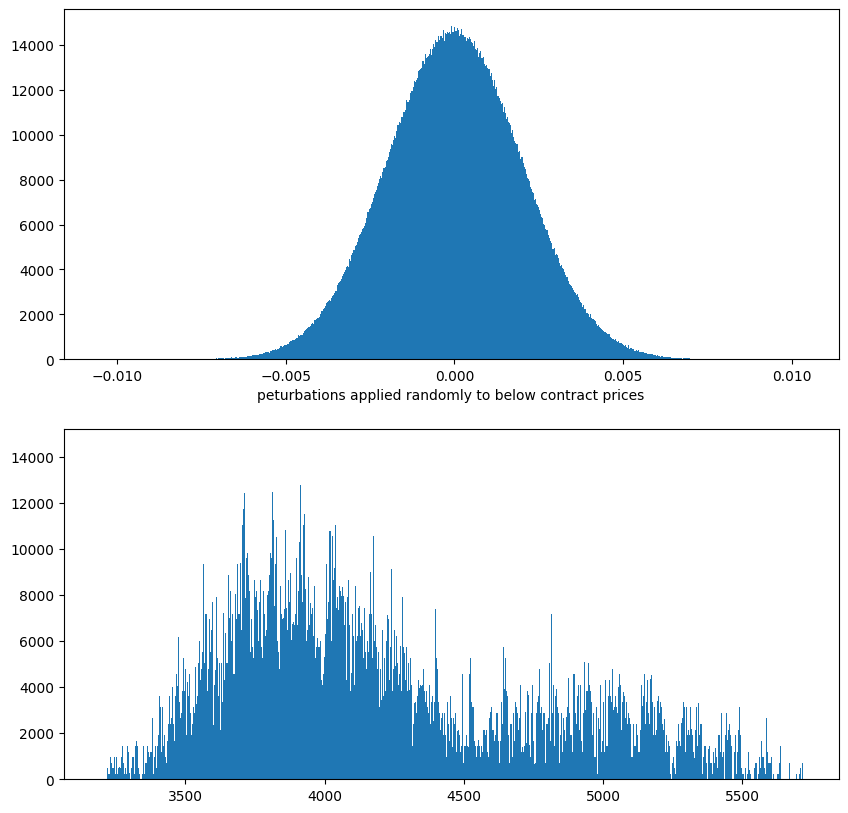

In [3]:
data = data[data[pricename]<data['spot_price']]
data = data[data[pricename]>data['spot_price']*0.01].reset_index(drop=True)

data['observed_price'] = data[pricename].apply(lambda x: max(x + np.random.normal(scale=0.002),0) if x > 0 else 0)
data = data[data['observed_price']>0]

p = data[pricename]-data['observed_price']
plotprices = data['observed_price']

fig,axs = plt.subplots(2,figsize=(10,10))
axs[0].hist(p,bins=int(len(p)**0.5))
axs[0].set_xlabel('peturbations applied randomly to below contract prices')
axs[1].hist(plotprices,bins=int(len(plotprices)**0.5))
plt.show()

# training procedure

In [4]:
from convsklearn import convsklearn
trainer = convsklearn()
help(trainer)
print('instance variables:')
trainer.__dict__

Help on convsklearn in module convsklearn.convsklearn object:

class convsklearn(builtins.object)
 |  convsklearn(target_name='observed_price', excluded_features=['barrier_price', 'asian', 'observed_price', 'outin', 'updown', 'n_fixings'])
 |
 |  a proprietary class of convenience wrappers for sklearn
 |
 |  Methods defined here:
 |
 |  __init__(self, target_name='observed_price', excluded_features=['barrier_price', 'asian', 'observed_price', 'outin', 'updown', 'n_fixings'])
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  load_data(self, data)
 |
 |  preprocess_data(self, development_dates, test_dates)
 |
 |  run_dnn(self, print_details=True)
 |
 |  test_prediction_accuracy(self)
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object

instance variables:


{'raw_data': Empty DataFrame
 Columns: []
 Index: [],
 'dataset': Empty DataFrame
 Columns: []
 Index: [],
 'target_name': 'observed_price',
 'excluded_features': ['barrier_price',
  'asian',
  'observed_price',
  'outin',
  'updown',
  'n_fixings'],
 'numerical_features': [],
 'categorical_features': [],
 'feature_set': [],
 'n_features': 0,
 'development_dates': {},
 'test_dates': {},
 'train_data': {},
 'test_data': {},
 'train_X': {},
 'train_y': {},
 'test_X': {},
 'test_y': {},
 'preprocessor': None,
 'pipeline': None,
 'model': None,
 'model_fit': None,
 'dnn_runtime': 0,
 'numerical_scaler': StandardScaler()}

In [5]:
trainer.load_data(data)
trainer.__dict__
trainer.dataset

,spot_price,strike_price,barrier,days_to_maturity,updown,outin,w,barrier_type_name,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,calculation_date,date,barrier_price,observed_price
0,4424.00000,3981.60000,2212.00000,60,Down,Out,call,DownOut,0.00000,0.00000,0.04000,0.04949,26.62607,-0.61054,6.49034,0.15574,2022-01-26 14:39:54.042,2022-01-26,519.00142,3981.60147
1,4424.00000,3981.60000,2212.00000,60,Down,Out,put,DownOut,0.00000,0.00000,0.04000,0.04949,26.62607,-0.61054,6.49034,0.15574,2022-01-26 14:39:54.042,2022-01-26,36.84016,3981.60063
2,4424.00000,3981.60000,2212.00000,60,Down,In,call,DownIn,0.00000,0.00000,0.04000,0.04949,26.62607,-0.61054,6.49034,0.15574,2022-01-26 14:39:54.042,2022-01-26,0.00000,3981.59764
3,4424.00000,3981.60000,2212.00000,60,Down,In,put,DownIn,0.00000,0.00000,0.04000,0.04949,26.62607,-0.61054,6.49034,0.15574,2022-01-26 14:39:54.042,2022-01-26,9.99191,3981.60139
4,4424.00000,3981.60000,2212.00000,90,Down,Out,call,DownOut,0.00000,0.00000,0.04000,0.04949,26.62607,-0.61054,6.49034,0.15574,2022-01-26 14:39:54.042,2022-01-26,546.03043,3981.59938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12322555,5813.50000,5668.16250,8720.25000,540,Up,In,put,UpIn,0.00000,0.00000,0.04000,0.08750,1.98223,-0.65710,1.70557,0.01895,2024-10-15 16:50:04.131,2024-10-15,5.59611,5668.16385
12322556,5813.50000,5668.16250,8720.25000,720,Up,Out,call,UpOut,0.00000,0.00000,0.04000,0.08750,1.98223,-0.65710,1.70557,0.01895,2024-10-15 16:50:04.131,2024-10-15,760.64673,5668.16167
12322557,5813.50000,5668.16250,8720.25000,720,Up,Out,put,UpOut,0.00000,0.00000,0.04000,0.08750,1.98223,-0.65710,1.70557,0.01895,2024-10-15 16:50:04.131,2024-10-15,413.16117,5668.16050
12322558,5813.50000,5668.16250,8720.25000,720,Up,In,call,UpIn,0.00000,0.00000,0.04000,0.08750,1.98223,-0.65710,1.70557,0.01895,2024-10-15 16:50:04.131,2024-10-15,237.78885,5668.16133


## preprocessing

In [6]:
dates = pd.Series(np.sort(data['date'].unique()))
dates

0      2022-01-26
1      2022-01-27
2      2022-01-28
3      2022-01-31
4      2022-02-01
          ...    
679    2024-10-09
680    2024-10-10
681    2024-10-11
682    2024-10-14
683    2024-10-15
Length: 684, dtype: object

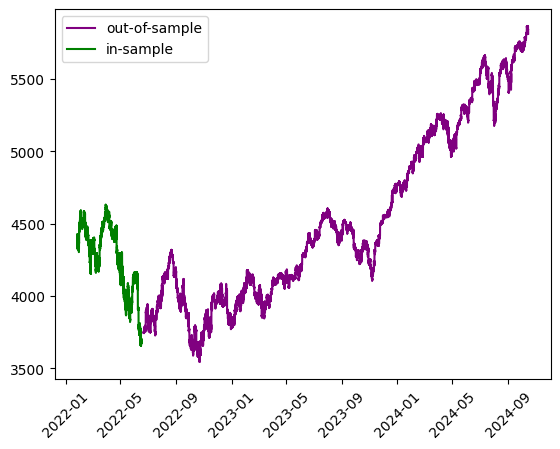

In [7]:
development_dates = dates[:100]
test_dates = dates[~dates.isin(development_dates)]
trainer.preprocess_data(development_dates,test_dates)

## training

In [ ]:
trainer.run_dnn()


training on 1865920 samples...

alpha: 0.01
hidden_layer_sizes: (14, 14)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001


In [ ]:
print('instance varianbles:')
trainer.__dict__

In [ ]:
trainer.model_fit

### initial test

In [ ]:
train_test = trainer.test_prediction_accuracy()

## saving

In [ ]:
train_end = time.time()
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H%M%S%f"))
file_tag = str(train_end_tag + " " + filetag)
files_dir = os.path.join(models_dir,file_tag)

def save_model():
    if Path(files_dir).exists():
        pass
    else:
        os.mkdir(files_dir)
    file_dir = os.path.join(files_dir,file_tag)
    joblib.dump(trainer.__dict__,str(f"{file_dir}.pkl"))
    pd.set_option("display.max_columns",None)
    print(f"model saved to {file_dir}")

print(f"execute the command 'save_model()' to save the following model: {file_tag}")
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")